# Audio MNIST Classifier

<a href="https://colab.research.google.com/github/inspektral/audioMNIST-classifier/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This report its an overview of the repository and it goes over the details of data processing, architecture, training evaluation and prediction of a classifier for the audio MNIST dataset.

The Dataset contains 30,000 samples of spoken digits, 60 speakers, 0 to 9.

The classifier is a small 3 blocks CNN that predicts the digit starting from the MFCCs of the audio file.


In [23]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'audioMNIST-classifier'
    repo_path = f'/content/{repo_name}'
    
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/audioMNIST-classifier.git
        os.chdir(repo_path)
        !pip install -r requirements.txt
        !git clone https://github.com/soerenab/AudioMNIST.git data/AudioMNIST

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Predictions

To run the prediction script it is sufficient to run the predict.py script, the configuration for the prediction is in the config file. The preditions will run on all the data in the DATA_PATH folder and safe a pandas dataframe in the a .csv in the RESULTS_PATH file.

In the predict_data folder there are already some files that can be used for predictions. Mind that the files are trimmed at 1s, so everything after the 1s mark will be discarded and not seen by the model.

In [40]:
!python predict.py

Starting prediction...
  0%|                                                    | 0/20 [00:00<?, ?it/s]/home/tito/miniconda3/envs/cuda-pytorch/lib/python3.10/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.68it/s]
Predictions saved to predictions.csv


In [41]:
predicitons_df = pd.read_csv('predictions.csv')
predicitons_df

,filepath,predicted_label
0,"('predict_data/giulio_05.wav',)",5
1,"('predict_data/giulio_06.wav',)",8
2,"('predict_data/giulio_04.wav',)",4
3,"('predict_data/giulio_09.wav',)",9
4,"('predict_data/giulio_08.wav',)",8
5,"('predict_data/giulio_03.wav',)",3
6,"('predict_data/giulio_07.wav',)",7
7,"('predict_data/giulio_02.wav',)",2
8,"('predict_data/giulio_00.wav',)",0
9,"('predict_data/giulio_01.wav',)",1


## Data

### Dataset

The AudioMNIST dataset is an open-source collection of 30,000 audio recordings of English spoken digits (0-9).

### Processing

The processing applied on the data is:
- Normalization
- Resampling
- Trimming
- MFCC

### Loading

The data is loaded with an ad hoc pytorch dataset class (see mfccdataset.py) and pytorch dataloaders(see utils)

## Architecture

## Training

## Evaluation

In [34]:
training_log_df = pd.read_csv('training_log.csv')
training_log_df

,epoch,train_accuracy,train_loss,test_accuracy,test_loss
0,0,10.000000,12.116056,10.000000,12.681695
1,1,98.320833,0.069607,96.833333,0.113582
2,2,99.175000,0.033076,97.583333,0.085033
3,3,99.600000,0.017864,98.133333,0.058794
4,4,99.812500,0.010980,98.400000,0.050530
5,5,99.537500,0.017241,97.683333,0.068890


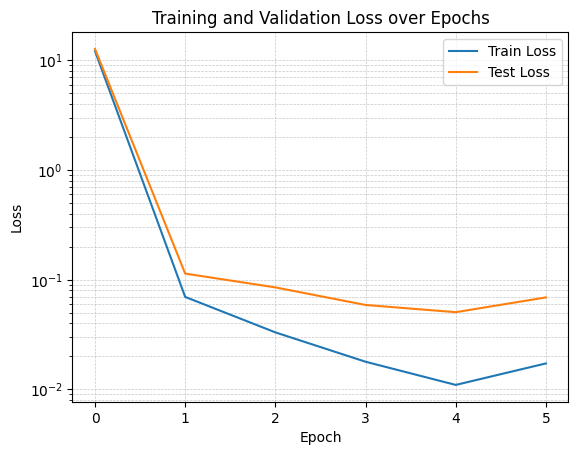

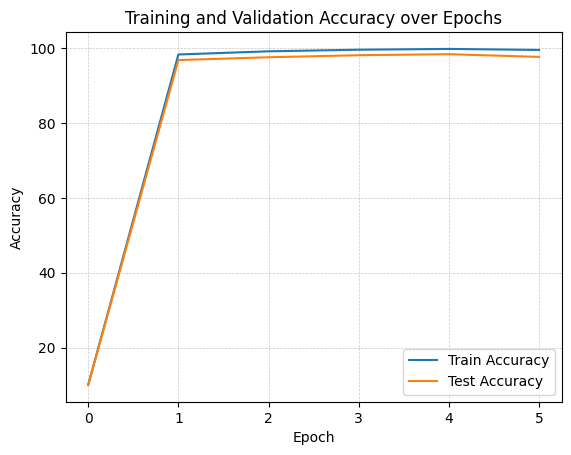

In [32]:
fig, ax = plt.subplots()
ax.plot(training_log_df['epoch'], training_log_df['train_loss'], label='Train Loss')
ax.plot(training_log_df['epoch'], training_log_df['test_loss'], label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss over Epochs')
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(training_log_df['epoch'], training_log_df['train_accuracy'], label='Train Accuracy')
ax.plot(training_log_df['epoch'], training_log_df['test_accuracy'], label='Test Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy over Epochs')
ax.set_yscale('linear')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.show()